# Introduction

Welcome to the Object Detection Project! This notebook provides a comprehensive overview of an object detection pipeline built using PyTorch Lightning and Faster R-CNN. The project encompasses synthetic data generation, model training, and inference testing.

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

### Necessary imports

In [2]:
# Fix path
import sys
from pathlib import Path

root_dir = str(Path().cwd().parent)
if root_dir not in sys.path:
    sys.path.append(root_dir)

In [3]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

from src.dataset import DetectionDataModule
from src.model import DetectionLightningModule
from src.utils import predict, plot_predictions

# Supress warnings
import warnings

warnings.filterwarnings("ignore")

---

## Data

### Data Overview

The dataset used in this project is synthetically generated to include three distinct classes:

- iron
- wood
- brick

Each synthetic image contains a single object from one of these classes, placed randomly on various background images. The dataset is split into training and validation sets to facilitate effective model evaluation.

Dataset Structure:

```
data/
│
├── synth_data/
│   ├── img_1.png
│   ├── img_2.png
│   ├── img_3.png
│   └── ...
│
├── train.csv
└── valid.csv
```

***synth_data/**: Contains all synthetic images.
**train.csv**: Annotations for the training set.
**valid.csv**: Annotations for the validation set.

CSV Annotation Format:

- **filepath**: Path to the image file.
- **label**: Class label of the object.
- **x1, y1, x2, y2**: Bounding box coordinates in Pascal VOC format.


In [4]:
# Read data file
data = pd.read_csv(f"{root_dir}/data/data.csv")
data.sample(5)

,filepath,label,x1,y1,x2,y2
54,data/synth_data/brick_9e9445bc.png,brick,846,43,920,120
5,data/synth_data/wood_9aa04af0.png,wood,1205,929,1265,989
50,data/synth_data/brick_9e585af2.png,brick,198,273,262,339
42,data/synth_data/brick_9d7ad9d4.png,brick,851,483,960,596
41,data/synth_data/brick_9d69d51c.png,brick,379,281,427,331


In [5]:
train_data = pd.read_csv(f"{root_dir}/data/train.csv")
valid_data = pd.read_csv(f"{root_dir}/data/valid.csv")
print(len(train_data), len(valid_data))

48 12


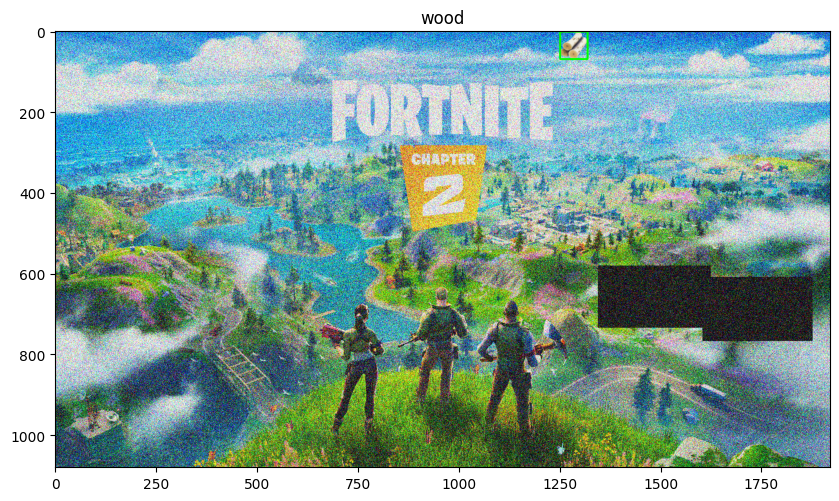

In [6]:
# Check visually
def plot_sample(sample: pd.DataFrame) -> None:
    filepath = sample.filepath
    label = sample.label
    bbox = sample[["x1", "y1", "x2", "y2"]].values.tolist()
    img = cv2.imread(f"{root_dir}/{filepath}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.rectangle(
        img, tuple(bbox[:2]), tuple(bbox[-2:]), color=(0, 255, 0), thickness=4
    )
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(label)


random_sample = data.sample(random_state=404)
plot_sample(sample=random_sample.iloc[0])

---

## Model Training

Ensure that your environment has the necessary libraries installed. It's recommended to use a virtual environment to manage dependencies.

In [7]:
# Initialize DataModule
data_module = DetectionDataModule(
    data_dir=f"{root_dir}/data",
    batch_size=4,
    num_workers=8,
)

In [8]:
# Initialize Model
model_module = DetectionLightningModule(
    num_classes=4,  # 3 classes + background
    lr=0.005,
)

In [9]:
checkpoint_callback = ModelCheckpoint(
    monitor="map",
    dirpath="model/",
    filename="fasterrcnn-{epoch:02d}-{map:.2f}",
    save_top_k=1,
    mode="max",
    verbose=True,
)
early_stop_callback = EarlyStopping(
    monitor="map",
    patience=5,
    mode="max",
)

# Initialize Trainer
trainer = pl.Trainer(
    max_epochs=20,
    log_every_n_steps=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator="cpu",
    logger=TensorBoardLogger(save_dir="logs/"),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (mps), used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [10]:
trainer.fit(model=model_module, datamodule=data_module)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type                 | Params | Mode 
--------------------------------------------------------
0 | model  | FasterRCNN           | 41.3 M | train
1 | metric | MeanAveragePrecision | 0      | train
--------------------------------------------------------
41.1 M    Trainable params
222 K     Non-trainable params
41.3 M    Total params
165.238   Total estimated model params size (MB)
190       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 12: 'map' reached 0.17836 (best 0.17836), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=00-map=0.18.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 24: 'map' reached 0.28238 (best 0.28238), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=01-map=0.28.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 36: 'map' reached 0.31237 (best 0.31237), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=02-map=0.31.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 48: 'map' reached 0.57041 (best 0.57041), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=03-map=0.57.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 60: 'map' reached 0.60519 (best 0.60519), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=04-map=0.61.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 72: 'map' reached 0.65860 (best 0.65860), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=05-map=0.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 84: 'map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 96: 'map' reached 0.67620 (best 0.67620), saving model to '/computer_vision_task_example/notebooks/model/fasterrcnn-epoch=07-map=0.68.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 108: 'map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 120: 'map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 132: 'map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 144: 'map' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 156: 'map' was not in top 1


In [ ]:
# Save the final model
trainer.save_checkpoint("model/fasterrcnn_final.pth", weights_only=True)

In [11]:
metrics = trainer.logged_metrics
history = checkpoint_callback.best_model_score.cpu().numpy()

print(f"Best Validation mAP: {history}")

Best Validation mAP: 0.6762009263038635


### Tensorboard graphs

<img src="tb.png" width=400 height=400 />

## Check Inference

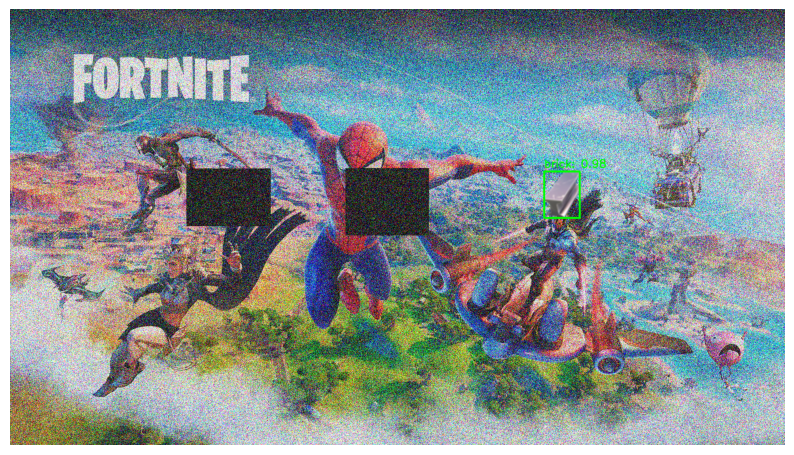

In [18]:
# Let's predict a training example
random_sample = train_data.sample(random_state=100500)
img_path = random_sample.iloc[0].filepath
img_path
img = cv2.imread(img_path)

predictions = predict(
    image=img, device="cpu", model=model_module.model, inference_thresh=0.5
)
plot_predictions(img=img, predictions=predictions)

## Conclusion

In this notebook, we've walked through the complete pipeline of an object detection project using Faster R-CNN and PyTorch Lightning. Starting from data preparation, through model training and inference testing.

Key Highlights:

- Synthetic Data Generation: Created a simple dataset with clear annotations for three distinct object classes.
- Model Training: Leveraged PyTorch Lightning for efficient training, incorporating best practices like checkpointing and early stopping.
- Inference Testing: Successfully deployed the trained model to perform object detection on new images, visualizing the results effectively.
- This project serves as a robust foundation for further enhancements, such as expanding dataset, integrating more complex data augmentation techniques, or deploying the model in real-world applications.
